# Data Processing with Spark (PySpark) and Hadoop

In [1]:
from pyspark.sql import SparkSession

In [2]:
# Initialize Spark session
spark = SparkSession.builder.appName("AmazonAppliancesReviewAnalysis").getOrCreate()

In [3]:
spark

# Data Loading

In [ ]:
# Load the datasets
reviews_df = spark.read.json("hdfs://namenode:8020/data/appliances/Appliances.jsonl")
meta_df = spark.read.json("hdfs://namenode:8020/data/appliances/meta_Appliances.jsonl")

# Initial Examination

In [5]:
# Initial inspection of reviews
print("Reviews Schema:")
reviews_df.printSchema()

print("Sample review records:")
reviews_df.show(10, truncate=False)

print("Reviews record count:", reviews_df.count())

print("Basic statistics for review ratings:")
reviews_df.select("rating").describe().show()

Reviews Schema:
root
 |-- asin: string (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- images: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attachment_type: string (nullable = true)
 |    |    |-- large_image_url: string (nullable = true)
 |    |    |-- medium_image_url: string (nullable = true)
 |    |    |-- small_image_url: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- title: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- verified_purchase: boolean (nullable = true)

Sample review records:
+----------+------------+------+-----------+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [6]:
# Initial inspection of metadata
print("Metadata Schema:")
meta_df.printSchema()

print("Sample metadata records:")
meta_df.show(10, truncate=False)

print("Metadata record count:", meta_df.count())

print("Basic statistics for product price and average_rating:")
meta_df.select("price", "average_rating").describe().show()

Metadata Schema:
root
 |-- author: struct (nullable = true)
 |    |-- about: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- avatar: string (nullable = true)
 |    |-- name: string (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- bought_together: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- details: struct (nullable = true)
 |    |-- AC Adapter Current: string (nullable = true)
 |    |-- Access Location: string (nullable = true)
 |    |-- Accessory Connection Type: string (nullable = true)
 |    |-- Active Ingredients: string (nullable = true)
 |    |-- Actors: string (nullable = true)
 |    |-- Actuator Type: string (nullable = true)
 |    |-- Additional product features: string (nullable = true)
 |    |-- Adjustable Temperature Control: string (nullable = true)
 | 

+------+--------------+---------------+--------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Metadata record count: 94327
Basic statistics for product price and average_rating:
+-------+------------------+------------------+
|summary|             price|    average_rating|
+-------+------------------+------------------+
|  count|             46726|             94327|
|   mean| 86.47995398707185|   4.1188588633159|
| stddev|325.31839745756395|0.8640397564950916|
|    min|              0.01|               1.0|
|    max|          21095.62|               5.0|
+-------+------------------+------------------+



# Cleaning & Preparation


In [7]:
# Check duplicate count in reviews based on key fields
duplicate_reviews_count = reviews_df.count() - reviews_df.dropDuplicates(['user_id', 'parent_asin', 'timestamp']).count()
print(f"Duplicate review records based on user_id, parent_asin, timestamp: {duplicate_reviews_count}")

# Check duplicate count in metadata based on parent_asin (should be unique)
duplicate_meta_count = meta_df.count() - meta_df.dropDuplicates(['parent_asin']).count()
print(f"Duplicate metadata records based on parent_asin: {duplicate_meta_count}")

# Count missing/null values per column in reviews
from pyspark.sql.functions import col, sum as _sum
missing_reviews = reviews_df.select([_sum(col(c).isNull().cast("int")).alias(c) for c in reviews_df.columns])
print("Missing/null values count per column in reviews:")
missing_reviews.show()

# Count missing/null values per column in metadata
missing_meta = meta_df.select([_sum(col(c).isNull().cast("int")).alias(c) for c in meta_df.columns])
print("Missing/null values count per column in metadata:")
missing_meta.show()

Duplicate review records based on user_id, parent_asin, timestamp: 22657
Duplicate metadata records based on parent_asin: 0
Missing/null values count per column in reviews:
+----+------------+------+-----------+------+----+---------+-----+-------+-----------------+
|asin|helpful_vote|images|parent_asin|rating|text|timestamp|title|user_id|verified_purchase|
+----+------------+------+-----------+------+----+---------+-----+-------+-----------------+
|   0|           0|     0|          0|     0|   0|        0|    0|      0|                0|
+----+------------+------+-----------+------+----+---------+-----+-------+-----------------+

Missing/null values count per column in metadata:
+------+--------------+---------------+----------+-----------+-------+--------+------+-------------+-----------+-----+-------------+-----+--------+-----+------+
|author|average_rating|bought_together|categories|description|details|features|images|main_category|parent_asin|price|rating_number|store|subtitle|tit

In [8]:
# Remove duplicate reviews based on unique keys
reviews_cleaned = reviews_df.dropDuplicates(['user_id', 'parent_asin', 'timestamp'])

# Fill missing helpful_vote with 0 (assuming no votes means zero)
reviews_cleaned = reviews_cleaned.fillna({'helpful_vote': 0})

# Cast rating and helpful_vote to correct types explicitly
reviews_cleaned = reviews_cleaned.withColumn("rating", reviews_cleaned["rating"].cast("float")) \
                                 .withColumn("helpful_vote", reviews_cleaned["helpful_vote"].cast("int"))

# Cast price to float, average_rating to float
meta_cleaned = meta_df.withColumn("price", meta_df["price"].cast("float")) \
                           .withColumn("average_rating", meta_df["average_rating"].cast("float"))

# Rename column
meta_cleaned = meta_cleaned.withColumnRenamed("title", "metadata_title")

# Cache cleaned DataFrames for efficient reuse
reviews_cleaned.cache()
meta_cleaned.cache()

print("Reviews cleaning complete. Records count:", reviews_cleaned.count())
print("Metadata cleaning complete. Records count:", meta_cleaned.count())

Reviews cleaning complete. Records count: 2105948
Metadata cleaning complete. Records count: 94327


In [ ]:
# Join reviews with product metadata on parent_asin
joined_df = reviews_cleaned.join(meta_cleaned, on='parent_asin', how='inner')

# Cache the joined DataFrame for performance
joined_df.cache()

# Exploratory Data Analysis (EDA)

In [9]:
# Average rating and helpful votes per main category
category_stats = joined_df.groupBy('main_category') \
    .agg(
        {'rating': 'avg', 'helpful_vote': 'sum'}
    ) \
    .withColumnRenamed('avg(rating)', 'avg_rating') \
    .withColumnRenamed('sum(helpful_vote)', 'total_helpful_votes') \
    .orderBy('avg_rating', ascending=False)

category_stats.show(20, truncate=False)

# Rating distribution
rating_dist = joined_df.groupBy('rating').count().orderBy('rating', ascending=False)
rating_dist.show()

+-------------------------+------------------+-------------------+
|main_category            |avg_rating        |total_helpful_votes|
+-------------------------+------------------+-------------------+
|Video Games              |5.0               |0                  |
|GPS & Navigation         |5.0               |0                  |
|Movies & TV              |5.0               |0                  |
|Software                 |4.625             |2                  |
|Arts, Crafts & Sewing    |4.5504587155963305|205                |
|Office Products          |4.4863325740318905|1440               |
|Books                    |4.4787878787878785|662                |
|Musical Instruments      |4.416139240506329 |463                |
|All Beauty               |4.3534883720930235|223                |
|Pet Supplies             |4.334732423924449 |996                |
|All Electronics          |4.318021201413427 |3124               |
|Tools & Home Improvement |4.315216475932219 |367356          

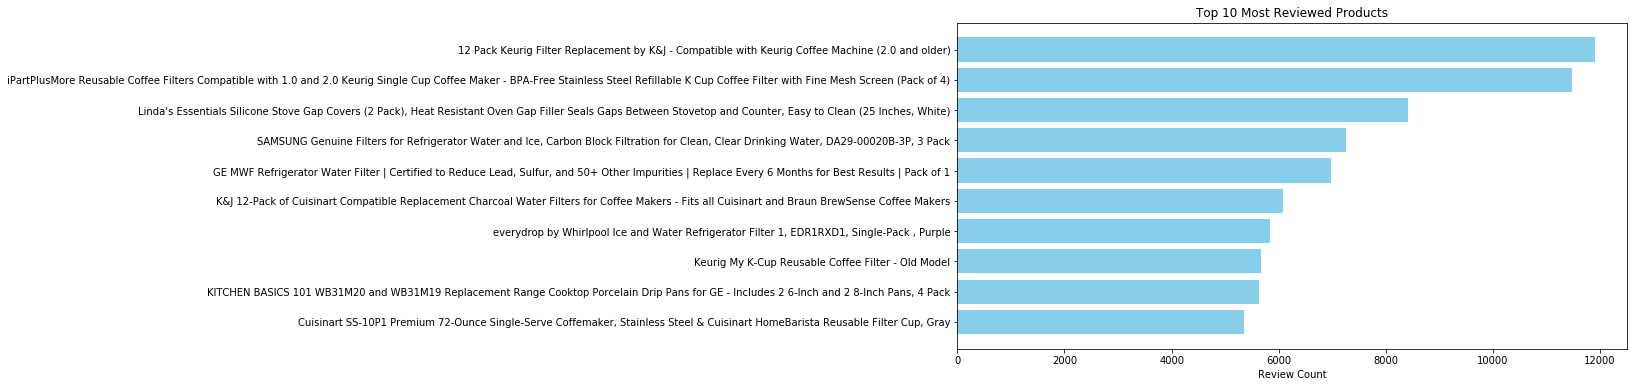

In [16]:
# Top 10 reviewed product titles
top_category = joined_df.groupBy('parent_asin', 'metadata_title') \
    .count() \
    .orderBy('count', ascending=False) \
    .limit(10)

# Convert to pandas for plotting
import pandas as pd

top_category_pd = top_category.toPandas()

# Plot bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.barh(top_category_pd['metadata_title'], top_category_pd['count'], color='skyblue')
plt.xlabel('Review Count')
plt.title('Top 10 Most Reviewed Products')
plt.gca().invert_yaxis()
plt.show()

# Data Preprocessing & Feature Engineering

In [11]:
from pyspark.sql.functions import when, length

# Label creation
joined_ml = joined_df.withColumn('label', when(col('rating') >= 4, 1).otherwise(0))

# Feature engineering: review length, helpful votes, price
joined_ml = joined_ml.withColumn('review_length', length('text'))

# Select relevant columns and drop nulls for ML
ml_data = joined_ml.select('label', 'review_length', 'helpful_vote', 'price') \
    .dropna()

# Data Preparation for MLlib

In [12]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=['review_length', 'helpful_vote', 'price'],
    outputCol='features')

# Apply assembler
data_prepared = assembler.transform(ml_data)

# Train/test split
train, test = data_prepared.randomSplit([0.8, 0.2], seed=42)

# Model Selection & Training

In [13]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(train)

# Model Evaluation

In [14]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions = lr_model.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol='label')
auc = evaluator.evaluate(predictions, {evaluator.metricName: 'areaUnderROC'})
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / 
        float(predictions.count())
print(f"Test set AUC: {auc:.3f}\nTest set Accuracy: {accuracy:.3f}")

Test set AUC: 0.658
Test set Accuracy: 0.806


# Model Results Visualization

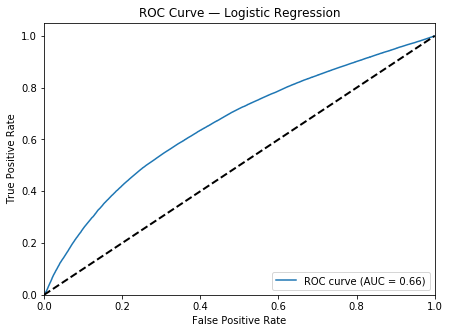

In [15]:
# Collect predicted probabilities and labels to pandas
preds_pd = predictions.select('probability', 'label').toPandas()
preds_pd['prob1'] = preds_pd['probability'].apply(lambda x: float(x[1]))

from sklearn.metrics import roc_curve, auc as sk_auc
fpr, tpr, thresholds = roc_curve(preds_pd['label'], preds_pd['prob1'])
roc_auc = sk_auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Logistic Regression')
plt.legend(loc='lower right')
plt.show()